# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score as roc, accuracy_score as acc, \
roc_curve, classification_report as cr, confusion_matrix as cm
from sklearn.inspection import permutation_importance


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

import time

# Get the data

In [2]:
data = pd.read_excel('C://Users//strol//Desktop//tennis.xlsx')

In [3]:
def data_read(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print('count isnull')
    print(data.isnull().sum())
    print()
    print('count duplicated', sum(data.duplicated()))

In [4]:
data_read(data)

,name,floor,part,player1,player2,rank1,rank2,coef1,coef2,p1win
0,WTA Warsaw Q,clay,0.5,Maleckova J.,Schunk N. M.,216,147,3.25,1.33,1
1,WTA Warsaw Q,clay,0.5,Lee G.,Bednarz Z.,146,10000,1.04,10.50,1
2,WTA Warsaw Q,clay,0.5,Baindl K.,Hatouka Y.,190,225,1.37,3.00,1
3,WTA Warsaw Q,clay,0.5,Hertel A.,Ignatik A.,777,154,6.50,1.10,0
4,WTA Warsaw Q,clay,0.5,Ewald W.,Papamichail D.,10000,180,13.50,1.02,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     42 non-null     object 
 1   floor    42 non-null     object 
 2   part     42 non-null     float64
 3   player1  42 non-null     object 
 4   player2  42 non-null     object 
 5   rank1    42 non-null     int64  
 6   rank2    42 non-null     int64  
 7   coef1    42 non-null     float64
 8   coef2    42 non-null     float64
 9   p1win    42 non-null     int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 3.4+ KB


None

,part,rank1,rank2,coef1,coef2,p1win
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.333333,405.714286,388.523810,2.542381,3.828333,0.523810
std,0.332061,1526.629881,1521.347754,2.405857,4.821494,0.505487
min,0.062500,1.000000,45.000000,1.010000,1.020000,0.000000
25%,0.062500,105.750000,100.000000,1.330000,1.592500,0.000000
50%,0.125000,132.500000,154.000000,1.720000,2.100000,1.000000
75%,0.500000,190.000000,188.750000,2.327500,3.237500,1.000000
max,1.000000,10000.000000,10000.000000,13.500000,26.000000,1.000000


count isnull
name       0
floor      0
part       0
player1    0
player2    0
rank1      0
rank2      0
coef1      0
coef2      0
p1win      0
dtype: int64

count duplicated 0


<b>ТУТ НУЖНЫ ГРАФИКИ!!!!</b>

Разделяем колонки на количественные и качественные.

# EDA

In [5]:
cat_col, quant_col = [], []

for i in data.columns:
    if data[i].dtype == 'float64' or data[i].dtype == 'int64':
        quant_col.append(i)
    else:
        cat_col.append(i)

quant_col.remove('p1win')
print('Колонки с категориальными признаками:')
print(cat_col)
print()
print('Колонки с количественными признаками:')
print(quant_col)

Колонки с категориальными признаками:
['name', 'floor', 'player1', 'player2']

Колонки с количественными признаками:
['part', 'rank1', 'rank2', 'coef1', 'coef2']


In [6]:
dataset = data.copy()
dataset[cat_col].head()

,name,floor,player1,player2
0,WTA Warsaw Q,clay,Maleckova J.,Schunk N. M.
1,WTA Warsaw Q,clay,Lee G.,Bednarz Z.
2,WTA Warsaw Q,clay,Baindl K.,Hatouka Y.
3,WTA Warsaw Q,clay,Hertel A.,Ignatik A.
4,WTA Warsaw Q,clay,Ewald W.,Papamichail D.


Закодируем наши категориальные признаки.

In [7]:
encoder = OrdinalEncoder()

dataset.loc[:, cat_col] = encoder.fit_transform(dataset.loc[:, cat_col]).astype('int64')

In [8]:
print('Распределение классов в датасете:')
display(dataset['p1win'].value_counts(normalize=True))

Распределение классов в датасете:


1    0.52381
0    0.47619
Name: p1win, dtype: float64

Это показывает что 1-й игрок выигрывает немного чаще чем 2-й.

In [9]:
x_dat = dataset.drop('p1win', axis=1)
y_dat = dataset['p1win']

In [10]:
x_train, x_test, y_train, y_test = tts(x_dat, y_dat, random_state=0,
                                      stratify=y_dat)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(31, 9) (11, 9) (31,) (11,)


Масштабируем признаки.

In [11]:
scaler = StandardScaler()

x_train.loc[:, quant_col] = scaler.fit_transform(x_train.loc[:, quant_col])
x_test.loc[:, quant_col] = scaler.fit_transform(x_test.loc[:, quant_col])

In [12]:
print('Распределение классов в тренировочной выборке:')
display(y_train.value_counts(normalize=True))
print('Распределение классов в тестовой выборке:')
display(y_test.value_counts(normalize=True))

Распределение классов в тренировочной выборке:


1    0.516129
0    0.483871
Name: p1win, dtype: float64

Распределение классов в тестовой выборке:


1    0.545455
0    0.454545
Name: p1win, dtype: float64

# Models

In [13]:
models = []

In [14]:
def predict(model, features, target, model_name):
    start_time = time.time()
    pred = model.predict(features)
    print('Время предсказания', time.time() - start_time)
    roc_auc = roc(target, model.predict_proba(features)[:, 1])
    accur = acc(target, pred)
    print('ROC_AUC =', roc_auc)
    print(cr(target, pred))
    models.append((model_name, roc_auc, accur))

In [15]:
start_time = time.time()

logreg = LogisticRegression(solver="liblinear", random_state=0).fit(x_train, y_train)
logreg_name = 'LogisticRegression'

print('Время обучения ', time.time() - start_time)

predict(logreg, x_test, y_test, logreg_name)

Время обучения  0.021394729614257812
Время предсказания 0.0070993900299072266
ROC_AUC = 0.6333333333333333
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.67      0.67      0.67         6

    accuracy                           0.64        11
   macro avg       0.63      0.63      0.63        11
weighted avg       0.64      0.64      0.64        11



Feature: 0, Score: 0.13489
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.64430
Feature: 3, Score: -0.01508
Feature: 4, Score: 0.02925
Feature: 5, Score: -0.28551
Feature: 6, Score: 0.54147
Feature: 7, Score: -0.48214
Feature: 8, Score: -0.12691


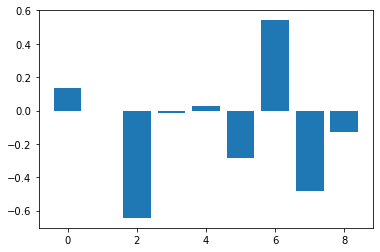

In [16]:
logreg_importance = logreg.coef_[0]
for i,v in enumerate(logreg_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(logreg_importance))], logreg_importance)
plt.show()

In [17]:
rfc = RandomForestClassifier

param_rfc = { 'n_estimators': range (10, 101, 10),
              'max_depth': [5, 7, 9],
              'max_features': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [2, 4, 6] 
            }


grid_rfc = GridSearchCV(rfc(random_state=0), param_rfc, cv=3, scoring='roc_auc', n_jobs = -1)
rfc_name = 'RandomForestClassifier'

start_time = time.time()
grid_rfc.fit(x_train, y_train)
print('Время обучения ', time.time() - start_time)

print(grid_rfc.best_params_)

predict(grid_rfc.best_estimator_, x_test, y_test, rfc_name)

Время обучения  78.50913166999817
{'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 40}
Время предсказания 0.015589475631713867
ROC_AUC = 0.7333333333333334
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.57      0.67      0.62         6

    accuracy                           0.55        11
   macro avg       0.54      0.53      0.53        11
weighted avg       0.54      0.55      0.54        11



In [18]:
rfc_features = pd.DataFrame(data = {'feature': x_train.columns, '%': grid_rfc.best_estimator_.feature_importances_})
rfc_features.sort_values('%', ascending=False).reset_index(drop=True)

,feature,%
0,rank2,0.280414
1,rank1,0.179563
2,coef1,0.147757
3,coef2,0.118714
4,player1,0.107911
5,player2,0.096005
6,part,0.048833
7,name,0.020803
8,floor,0.000000


In [19]:
knc = KNeighborsClassifier

param_knc = { 'n_neighbors': range (1, 20, 1)
            }

grid_knc = GridSearchCV(knc(n_jobs=-1), param_knc, cv=3, scoring='roc_auc', n_jobs=-1)
knc_name = 'KNeighborsClassifier'

start_time = time.time()
grid_knc.fit(x_train, y_train)
print('Время обучения ', time.time() - start_time)

print(grid_knc.best_params_)

predict(grid_knc.best_estimator_, x_test, y_test, knc_name)

Время обучения  0.3015437126159668
{'n_neighbors': 6}
Время предсказания 0.0
ROC_AUC = 0.7
              precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.67      0.33      0.44         6

    accuracy                           0.55        11
   macro avg       0.58      0.57      0.53        11
weighted avg       0.59      0.55      0.52        11



In [21]:
x_train_v, x_valid, y_train_v, y_valid = tts(x_train, y_train, test_size=0.25, random_state=0, stratify=y_train)

In [22]:
cbc = CatBoostClassifier(
    iterations = 2000,
    learning_rate = 0.02,
    depth = 3,
    loss_function='CrossEntropy',
    eval_metric = 'AUC',
    cat_features = cat_col, 
    random_state=0)

start_time = time.time()

cbc.fit(x_train_v, y_train_v, 
    use_best_model=True, 
    eval_set=(x_valid, y_valid),
    logging_level = 'Verbose',
    cat_features=cat_col)

print('Время обучения ', time.time() - start_time)

0:	test: 0.3125000	best: 0.3125000 (0)	total: 195ms	remaining: 6m 30s
1:	test: 0.3125000	best: 0.3125000 (0)	total: 197ms	remaining: 3m 17s
2:	test: 0.3125000	best: 0.3125000 (0)	total: 202ms	remaining: 2m 14s
3:	test: 0.5937500	best: 0.5937500 (3)	total: 207ms	remaining: 1m 43s
4:	test: 0.5937500	best: 0.5937500 (3)	total: 213ms	remaining: 1m 24s
5:	test: 0.5312500	best: 0.5937500 (3)	total: 218ms	remaining: 1m 12s
6:	test: 0.5312500	best: 0.5937500 (3)	total: 222ms	remaining: 1m 3s
7:	test: 0.5625000	best: 0.5937500 (3)	total: 228ms	remaining: 56.7s
8:	test: 0.5625000	best: 0.5937500 (3)	total: 233ms	remaining: 51.6s
9:	test: 0.6250000	best: 0.6250000 (9)	total: 238ms	remaining: 47.5s
10:	test: 0.6250000	best: 0.6250000 (9)	total: 244ms	remaining: 44.1s
11:	test: 0.6875000	best: 0.6875000 (11)	total: 249ms	remaining: 41.3s
12:	test: 0.6875000	best: 0.6875000 (11)	total: 254ms	remaining: 38.9s
13:	test: 0.7500000	best: 0.7500000 (13)	total: 260ms	remaining: 36.9s
14:	test: 0.7500000	b

138:	test: 0.7500000	best: 0.7500000 (13)	total: 911ms	remaining: 12.2s
139:	test: 0.7500000	best: 0.7500000 (13)	total: 916ms	remaining: 12.2s
140:	test: 0.7500000	best: 0.7500000 (13)	total: 924ms	remaining: 12.2s
141:	test: 0.7500000	best: 0.7500000 (13)	total: 929ms	remaining: 12.2s
142:	test: 0.7500000	best: 0.7500000 (13)	total: 932ms	remaining: 12.1s
143:	test: 0.7500000	best: 0.7500000 (13)	total: 940ms	remaining: 12.1s
144:	test: 0.7500000	best: 0.7500000 (13)	total: 946ms	remaining: 12.1s
145:	test: 0.7500000	best: 0.7500000 (13)	total: 952ms	remaining: 12.1s
146:	test: 0.7500000	best: 0.7500000 (13)	total: 958ms	remaining: 12.1s
147:	test: 0.7500000	best: 0.7500000 (13)	total: 963ms	remaining: 12.1s
148:	test: 0.7500000	best: 0.7500000 (13)	total: 968ms	remaining: 12s
149:	test: 0.7500000	best: 0.7500000 (13)	total: 973ms	remaining: 12s
150:	test: 0.7500000	best: 0.7500000 (13)	total: 978ms	remaining: 12s
151:	test: 0.7500000	best: 0.7500000 (13)	total: 983ms	remaining: 12s


282:	test: 0.7500000	best: 0.7500000 (13)	total: 1.66s	remaining: 10.1s
283:	test: 0.7500000	best: 0.7500000 (13)	total: 1.67s	remaining: 10.1s
284:	test: 0.7500000	best: 0.7500000 (13)	total: 1.67s	remaining: 10.1s
285:	test: 0.7500000	best: 0.7500000 (13)	total: 1.68s	remaining: 10.1s
286:	test: 0.7500000	best: 0.7500000 (13)	total: 1.69s	remaining: 10.1s
287:	test: 0.7500000	best: 0.7500000 (13)	total: 1.69s	remaining: 10s
288:	test: 0.7500000	best: 0.7500000 (13)	total: 1.7s	remaining: 10s
289:	test: 0.7500000	best: 0.7500000 (13)	total: 1.7s	remaining: 10s
290:	test: 0.7500000	best: 0.7500000 (13)	total: 1.71s	remaining: 10s
291:	test: 0.7500000	best: 0.7500000 (13)	total: 1.71s	remaining: 10s
292:	test: 0.7500000	best: 0.7500000 (13)	total: 1.72s	remaining: 10s
293:	test: 0.7500000	best: 0.7500000 (13)	total: 1.72s	remaining: 9.99s
294:	test: 0.7500000	best: 0.7500000 (13)	total: 1.73s	remaining: 9.98s
295:	test: 0.7500000	best: 0.7500000 (13)	total: 1.73s	remaining: 9.97s
296:	t

426:	test: 0.7500000	best: 0.7500000 (13)	total: 2.42s	remaining: 8.91s
427:	test: 0.7500000	best: 0.7500000 (13)	total: 2.42s	remaining: 8.91s
428:	test: 0.7500000	best: 0.7500000 (13)	total: 2.43s	remaining: 8.9s
429:	test: 0.7500000	best: 0.7500000 (13)	total: 2.44s	remaining: 8.89s
430:	test: 0.7500000	best: 0.7500000 (13)	total: 2.44s	remaining: 8.89s
431:	test: 0.7500000	best: 0.7500000 (13)	total: 2.45s	remaining: 8.88s
432:	test: 0.7500000	best: 0.7500000 (13)	total: 2.45s	remaining: 8.88s
433:	test: 0.7500000	best: 0.7500000 (13)	total: 2.46s	remaining: 8.87s
434:	test: 0.7500000	best: 0.7500000 (13)	total: 2.46s	remaining: 8.87s
435:	test: 0.7500000	best: 0.7500000 (13)	total: 2.47s	remaining: 8.86s
436:	test: 0.7500000	best: 0.7500000 (13)	total: 2.47s	remaining: 8.85s
437:	test: 0.7500000	best: 0.7500000 (13)	total: 2.48s	remaining: 8.84s
438:	test: 0.7500000	best: 0.7500000 (13)	total: 2.48s	remaining: 8.84s
439:	test: 0.7500000	best: 0.7500000 (13)	total: 2.49s	remaining:

555:	test: 0.7500000	best: 0.7500000 (13)	total: 3.14s	remaining: 8.16s
556:	test: 0.7500000	best: 0.7500000 (13)	total: 3.15s	remaining: 8.16s
557:	test: 0.7500000	best: 0.7500000 (13)	total: 3.15s	remaining: 8.15s
558:	test: 0.7500000	best: 0.7500000 (13)	total: 3.16s	remaining: 8.15s
559:	test: 0.7500000	best: 0.7500000 (13)	total: 3.17s	remaining: 8.15s
560:	test: 0.7500000	best: 0.7500000 (13)	total: 3.17s	remaining: 8.14s
561:	test: 0.7500000	best: 0.7500000 (13)	total: 3.18s	remaining: 8.14s
562:	test: 0.7500000	best: 0.7500000 (13)	total: 3.19s	remaining: 8.13s
563:	test: 0.7500000	best: 0.7500000 (13)	total: 3.19s	remaining: 8.13s
564:	test: 0.7500000	best: 0.7500000 (13)	total: 3.2s	remaining: 8.12s
565:	test: 0.7500000	best: 0.7500000 (13)	total: 3.2s	remaining: 8.12s
566:	test: 0.7500000	best: 0.7500000 (13)	total: 3.21s	remaining: 8.11s
567:	test: 0.7500000	best: 0.7500000 (13)	total: 3.21s	remaining: 8.1s
568:	test: 0.7500000	best: 0.7500000 (13)	total: 3.22s	remaining: 8

682:	test: 0.7500000	best: 0.7500000 (13)	total: 3.86s	remaining: 7.45s
683:	test: 0.7500000	best: 0.7500000 (13)	total: 3.87s	remaining: 7.44s
684:	test: 0.7500000	best: 0.7500000 (13)	total: 3.88s	remaining: 7.44s
685:	test: 0.7500000	best: 0.7500000 (13)	total: 3.88s	remaining: 7.43s
686:	test: 0.7500000	best: 0.7500000 (13)	total: 3.89s	remaining: 7.43s
687:	test: 0.7500000	best: 0.7500000 (13)	total: 3.89s	remaining: 7.42s
688:	test: 0.7500000	best: 0.7500000 (13)	total: 3.9s	remaining: 7.42s
689:	test: 0.7500000	best: 0.7500000 (13)	total: 3.9s	remaining: 7.41s
690:	test: 0.7500000	best: 0.7500000 (13)	total: 3.91s	remaining: 7.4s
691:	test: 0.7500000	best: 0.7500000 (13)	total: 3.91s	remaining: 7.4s
692:	test: 0.7500000	best: 0.7500000 (13)	total: 3.92s	remaining: 7.39s
693:	test: 0.7500000	best: 0.7500000 (13)	total: 3.93s	remaining: 7.39s
694:	test: 0.7500000	best: 0.7500000 (13)	total: 3.93s	remaining: 7.38s
695:	test: 0.7500000	best: 0.7500000 (13)	total: 3.94s	remaining: 7.

820:	test: 0.7500000	best: 0.7500000 (13)	total: 4.6s	remaining: 6.61s
821:	test: 0.7500000	best: 0.7500000 (13)	total: 4.61s	remaining: 6.61s
822:	test: 0.7500000	best: 0.7500000 (13)	total: 4.62s	remaining: 6.61s
823:	test: 0.7500000	best: 0.7500000 (13)	total: 4.62s	remaining: 6.6s
824:	test: 0.7500000	best: 0.7500000 (13)	total: 4.63s	remaining: 6.59s
825:	test: 0.7500000	best: 0.7500000 (13)	total: 4.64s	remaining: 6.59s
826:	test: 0.7500000	best: 0.7500000 (13)	total: 4.64s	remaining: 6.58s
827:	test: 0.7500000	best: 0.7500000 (13)	total: 4.65s	remaining: 6.58s
828:	test: 0.7500000	best: 0.7500000 (13)	total: 4.65s	remaining: 6.57s
829:	test: 0.7500000	best: 0.7500000 (13)	total: 4.66s	remaining: 6.57s
830:	test: 0.7500000	best: 0.7500000 (13)	total: 4.66s	remaining: 6.56s
831:	test: 0.7500000	best: 0.7500000 (13)	total: 4.67s	remaining: 6.55s
832:	test: 0.7500000	best: 0.7500000 (13)	total: 4.67s	remaining: 6.55s
833:	test: 0.7500000	best: 0.7500000 (13)	total: 4.68s	remaining: 

951:	test: 0.7500000	best: 0.7500000 (13)	total: 5.33s	remaining: 5.87s
952:	test: 0.7500000	best: 0.7500000 (13)	total: 5.33s	remaining: 5.86s
953:	test: 0.7500000	best: 0.7500000 (13)	total: 5.34s	remaining: 5.85s
954:	test: 0.7500000	best: 0.7500000 (13)	total: 5.34s	remaining: 5.85s
955:	test: 0.7500000	best: 0.7500000 (13)	total: 5.35s	remaining: 5.84s
956:	test: 0.7500000	best: 0.7500000 (13)	total: 5.36s	remaining: 5.84s
957:	test: 0.7500000	best: 0.7500000 (13)	total: 5.36s	remaining: 5.83s
958:	test: 0.7500000	best: 0.7500000 (13)	total: 5.37s	remaining: 5.82s
959:	test: 0.7500000	best: 0.7500000 (13)	total: 5.37s	remaining: 5.82s
960:	test: 0.7500000	best: 0.7500000 (13)	total: 5.38s	remaining: 5.81s
961:	test: 0.7500000	best: 0.7500000 (13)	total: 5.38s	remaining: 5.8s
962:	test: 0.7500000	best: 0.7500000 (13)	total: 5.38s	remaining: 5.8s
963:	test: 0.7500000	best: 0.7500000 (13)	total: 5.39s	remaining: 5.79s
964:	test: 0.7500000	best: 0.7500000 (13)	total: 5.39s	remaining: 

1097:	test: 0.7500000	best: 0.7500000 (13)	total: 6.08s	remaining: 5s
1098:	test: 0.7500000	best: 0.7500000 (13)	total: 6.09s	remaining: 4.99s
1099:	test: 0.7500000	best: 0.7500000 (13)	total: 6.09s	remaining: 4.99s
1100:	test: 0.7500000	best: 0.7500000 (13)	total: 6.1s	remaining: 4.98s
1101:	test: 0.7500000	best: 0.7500000 (13)	total: 6.1s	remaining: 4.97s
1102:	test: 0.7500000	best: 0.7500000 (13)	total: 6.11s	remaining: 4.97s
1103:	test: 0.7500000	best: 0.7500000 (13)	total: 6.11s	remaining: 4.96s
1104:	test: 0.7500000	best: 0.7500000 (13)	total: 6.12s	remaining: 4.96s
1105:	test: 0.7500000	best: 0.7500000 (13)	total: 6.12s	remaining: 4.95s
1106:	test: 0.7500000	best: 0.7500000 (13)	total: 6.13s	remaining: 4.94s
1107:	test: 0.7500000	best: 0.7500000 (13)	total: 6.13s	remaining: 4.94s
1108:	test: 0.7500000	best: 0.7500000 (13)	total: 6.14s	remaining: 4.93s
1109:	test: 0.7500000	best: 0.7500000 (13)	total: 6.14s	remaining: 4.93s
1110:	test: 0.7500000	best: 0.7500000 (13)	total: 6.15s	

1210:	test: 0.7500000	best: 0.7500000 (13)	total: 6.67s	remaining: 4.34s
1211:	test: 0.7500000	best: 0.7500000 (13)	total: 6.67s	remaining: 4.34s
1212:	test: 0.7500000	best: 0.7500000 (13)	total: 6.68s	remaining: 4.33s
1213:	test: 0.7500000	best: 0.7500000 (13)	total: 6.68s	remaining: 4.33s
1214:	test: 0.7500000	best: 0.7500000 (13)	total: 6.69s	remaining: 4.32s
1215:	test: 0.7500000	best: 0.7500000 (13)	total: 6.69s	remaining: 4.32s
1216:	test: 0.7500000	best: 0.7500000 (13)	total: 6.7s	remaining: 4.31s
1217:	test: 0.7500000	best: 0.7500000 (13)	total: 6.7s	remaining: 4.3s
1218:	test: 0.7500000	best: 0.7500000 (13)	total: 6.71s	remaining: 4.3s
1219:	test: 0.7500000	best: 0.7500000 (13)	total: 6.71s	remaining: 4.29s
1220:	test: 0.7500000	best: 0.7500000 (13)	total: 6.72s	remaining: 4.29s
1221:	test: 0.7500000	best: 0.7500000 (13)	total: 6.72s	remaining: 4.28s
1222:	test: 0.7500000	best: 0.7500000 (13)	total: 6.73s	remaining: 4.28s
1223:	test: 0.7500000	best: 0.7500000 (13)	total: 6.73s

1351:	test: 0.7500000	best: 0.7500000 (13)	total: 7.41s	remaining: 3.55s
1352:	test: 0.7500000	best: 0.7500000 (13)	total: 7.42s	remaining: 3.55s
1353:	test: 0.7500000	best: 0.7500000 (13)	total: 7.43s	remaining: 3.54s
1354:	test: 0.7500000	best: 0.7500000 (13)	total: 7.43s	remaining: 3.54s
1355:	test: 0.7500000	best: 0.7500000 (13)	total: 7.44s	remaining: 3.53s
1356:	test: 0.7500000	best: 0.7500000 (13)	total: 7.44s	remaining: 3.53s
1357:	test: 0.7500000	best: 0.7500000 (13)	total: 7.45s	remaining: 3.52s
1358:	test: 0.7500000	best: 0.7500000 (13)	total: 7.45s	remaining: 3.52s
1359:	test: 0.7500000	best: 0.7500000 (13)	total: 7.46s	remaining: 3.51s
1360:	test: 0.7500000	best: 0.7500000 (13)	total: 7.46s	remaining: 3.5s
1361:	test: 0.7500000	best: 0.7500000 (13)	total: 7.47s	remaining: 3.5s
1362:	test: 0.7500000	best: 0.7500000 (13)	total: 7.47s	remaining: 3.49s
1363:	test: 0.7500000	best: 0.7500000 (13)	total: 7.48s	remaining: 3.49s
1364:	test: 0.7500000	best: 0.7500000 (13)	total: 7.4

1489:	test: 0.7500000	best: 0.7500000 (13)	total: 8.15s	remaining: 2.79s
1490:	test: 0.7500000	best: 0.7500000 (13)	total: 8.15s	remaining: 2.78s
1491:	test: 0.7500000	best: 0.7500000 (13)	total: 8.16s	remaining: 2.78s
1492:	test: 0.7500000	best: 0.7500000 (13)	total: 8.16s	remaining: 2.77s
1493:	test: 0.7500000	best: 0.7500000 (13)	total: 8.17s	remaining: 2.77s
1494:	test: 0.7500000	best: 0.7500000 (13)	total: 8.18s	remaining: 2.76s
1495:	test: 0.7500000	best: 0.7500000 (13)	total: 8.18s	remaining: 2.76s
1496:	test: 0.7500000	best: 0.7500000 (13)	total: 8.19s	remaining: 2.75s
1497:	test: 0.7500000	best: 0.7500000 (13)	total: 8.19s	remaining: 2.75s
1498:	test: 0.7500000	best: 0.7500000 (13)	total: 8.2s	remaining: 2.74s
1499:	test: 0.7500000	best: 0.7500000 (13)	total: 8.2s	remaining: 2.73s
1500:	test: 0.7500000	best: 0.7500000 (13)	total: 8.21s	remaining: 2.73s
1501:	test: 0.7500000	best: 0.7500000 (13)	total: 8.21s	remaining: 2.72s
1502:	test: 0.7500000	best: 0.7500000 (13)	total: 8.2

1630:	test: 0.7500000	best: 0.7500000 (13)	total: 8.89s	remaining: 2.01s
1631:	test: 0.7500000	best: 0.7500000 (13)	total: 8.9s	remaining: 2.01s
1632:	test: 0.7500000	best: 0.7500000 (13)	total: 8.91s	remaining: 2s
1633:	test: 0.7500000	best: 0.7500000 (13)	total: 8.91s	remaining: 2s
1634:	test: 0.7500000	best: 0.7500000 (13)	total: 8.92s	remaining: 1.99s
1635:	test: 0.7500000	best: 0.7500000 (13)	total: 8.92s	remaining: 1.99s
1636:	test: 0.7500000	best: 0.7500000 (13)	total: 8.93s	remaining: 1.98s
1637:	test: 0.7500000	best: 0.7500000 (13)	total: 8.93s	remaining: 1.97s
1638:	test: 0.7500000	best: 0.7500000 (13)	total: 8.94s	remaining: 1.97s
1639:	test: 0.7500000	best: 0.7500000 (13)	total: 8.94s	remaining: 1.96s
1640:	test: 0.7500000	best: 0.7500000 (13)	total: 8.95s	remaining: 1.96s
1641:	test: 0.7500000	best: 0.7500000 (13)	total: 8.95s	remaining: 1.95s
1642:	test: 0.7500000	best: 0.7500000 (13)	total: 8.96s	remaining: 1.95s
1643:	test: 0.7500000	best: 0.7500000 (13)	total: 8.96s	re

1774:	test: 0.7500000	best: 0.7500000 (13)	total: 9.66s	remaining: 1.22s
1775:	test: 0.7500000	best: 0.7500000 (13)	total: 9.66s	remaining: 1.22s
1776:	test: 0.7500000	best: 0.7500000 (13)	total: 9.67s	remaining: 1.21s
1777:	test: 0.7500000	best: 0.7500000 (13)	total: 9.67s	remaining: 1.21s
1778:	test: 0.7500000	best: 0.7500000 (13)	total: 9.68s	remaining: 1.2s
1779:	test: 0.7500000	best: 0.7500000 (13)	total: 9.68s	remaining: 1.2s
1780:	test: 0.7500000	best: 0.7500000 (13)	total: 9.69s	remaining: 1.19s
1781:	test: 0.7500000	best: 0.7500000 (13)	total: 9.69s	remaining: 1.19s
1782:	test: 0.7500000	best: 0.7500000 (13)	total: 9.7s	remaining: 1.18s
1783:	test: 0.7500000	best: 0.7500000 (13)	total: 9.7s	remaining: 1.18s
1784:	test: 0.7500000	best: 0.7500000 (13)	total: 9.71s	remaining: 1.17s
1785:	test: 0.7500000	best: 0.7500000 (13)	total: 9.71s	remaining: 1.16s
1786:	test: 0.7500000	best: 0.7500000 (13)	total: 9.72s	remaining: 1.16s
1787:	test: 0.7500000	best: 0.7500000 (13)	total: 9.72s

1912:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 473ms
1913:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 467ms
1914:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 462ms
1915:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 456ms
1916:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 451ms
1917:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 446ms
1918:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 440ms
1919:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 435ms
1920:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 429ms
1921:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 424ms
1922:	test: 0.7500000	best: 0.7500000 (13)	total: 10.4s	remaining: 418ms
1923:	test: 0.7500000	best: 0.7500000 (13)	total: 10.5s	remaining: 413ms
1924:	test: 0.7500000	best: 0.7500000 (13)	total: 10.5s	remaining: 408ms
1925:	test: 0.7500000	best: 0.7500000 (13)	total: 1

In [23]:
start_time = time.time()

cbc.fit(x_train, y_train, 
             cat_features=cat_col,
             logging_level = 'Silent',
            )

print('Время обучения ', time.time() - start_time)

cbc_pred = cbc.predict(x_test)

roc_auc_cbc = roc(y_test, cbc.predict_proba(x_test)[:, 1])
print('roc_auc для модели CatBoost на тестовой выборке: {}'.format(roc_auc_cbc))
acc_cbc = acc(y_test, cbc_pred)
print('accuracy для модели CatBoost на тестовой выборке {}'.format(acc_cbc))

models.append(('CatBoostClassifier', roc_auc_cbc, acc_cbc))

Время обучения  10.329073429107666
roc_auc для модели CatBoost на тестовой выборке: 0.4666666666666667
accuracy для модели CatBoost на тестовой выборке 0.36363636363636365


In [24]:
models = pd.DataFrame(models, columns=['name', 'roc_auc', 'accuracy'])

In [25]:
models

,name,roc_auc,accuracy
0,LogisticRegression,0.633333,0.636364
1,RandomForestClassifier,0.733333,0.545455
2,KNeighborsClassifier,0.700000,0.545455
3,CatBoostClassifier,0.466667,0.363636


<AxesSubplot:>

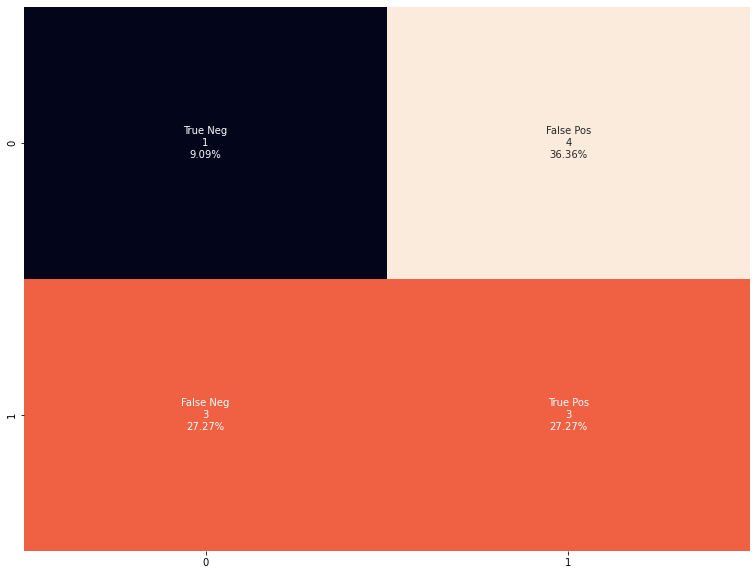

In [28]:
plt.figure(figsize=(13,10))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm(y_test, cbc_pred).flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm(y_test, cbc_pred).flatten()/np.sum(cm(y_test, cbc_pred))]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm(y_test, cbc_pred), annot=labels, fmt='', cbar=False)

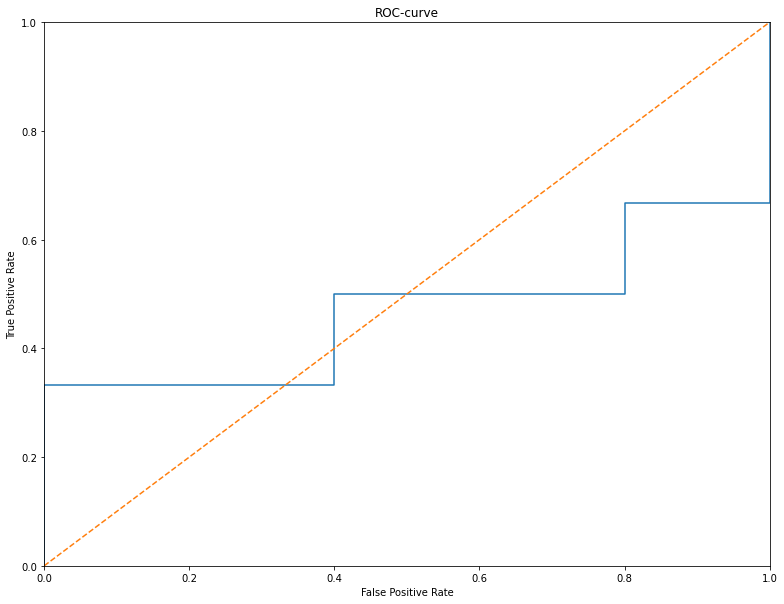

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, cbc.predict_proba(x_test)[:, 1])

plt.figure(figsize=(13,10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

In [27]:
cbc_features = pd.DataFrame(data = {'feature': x_test.columns, '%': cbc.feature_importances_})
cbc_features.sort_values('%', ascending=False).reset_index(drop=True)

,feature,%
0,rank2,45.478935
1,rank1,16.679160
2,player2,11.160686
3,coef2,9.847014
4,coef1,6.133369
5,player1,5.187106
6,part,4.120114
7,name,1.393616
8,floor,0.000000
